# Oxford Pet Dataset Classification with MobileNet34

This notebook demonstrates how to classify images from the Oxford-IIIT Pet Dataset using a modified MobileNet model. We'll cover:

- **Data Loading**: Preparing the dataset with a custom class and data loaders.
- **Model Training**: Fine-tuning a pre-trained MobileNet34 model with dropout and a custom classifier.
- **Testing and Evaluation**: Assessing the model's performance with metrics and visualizations.

## Prerequisites

- The Oxford-IIIT Pet Dataset should be uploaded to Colab or Google Drive.
- Required libraries: `torch`, `torchvision`, `PIL`, `sklearn`, `matplotlib`, `seaborn`.

Let’s get started!

## Some Imports and installation...bear with me

In [1]:


# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import datetime
import glob



In [2]:
data_dir = "../data/"

In [4]:
class OxfordPetDataset(Dataset):
    """Custom dataset for Oxford-IIIT Pet Dataset."""

    def __init__(self, img_dir, annotation_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_labels = []

        # Read annotation file (trainval.txt or test.txt)
        with open(annotation_file, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                img_name = parts[0] + ".jpg"  # Image file name
                label = int(parts[1]) - 1  # Convert to zero-based indexing
                self.image_labels.append((img_name, label))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_name, label = self.image_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")  # Open image as RGB

        if self.transform:
            image = self.transform(image)

        return image, label

def get_data_loaders(data_dir, batch_size=32, val_split=0.2):
    """Create data loaders for training, validation, and testing."""
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize to 224x224 (MobileNet input size)
        transforms.RandomHorizontalFlip(),  # Randomly flip for augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
        transforms.RandomRotation(10),  # Rotate up to 10 degrees
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])

    img_dir = os.path.join(data_dir, "images")
    annotation_file = os.path.join(data_dir, "annotations/trainval.txt")
    test_annotation_file = os.path.join(data_dir, "annotations/test.txt")

    # Create datasets
    dataset = OxfordPetDataset(img_dir, annotation_file, transform)
    test_dataset = OxfordPetDataset(img_dir, test_annotation_file, transform)

    # Split into train and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Test the data loaders (optional)
train_loader, val_loader, test_loader = get_data_loaders("../data/")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Train size: 2944, Validation size: 736, Test size: 3669


## Visualizing the transformations that we apply to the images

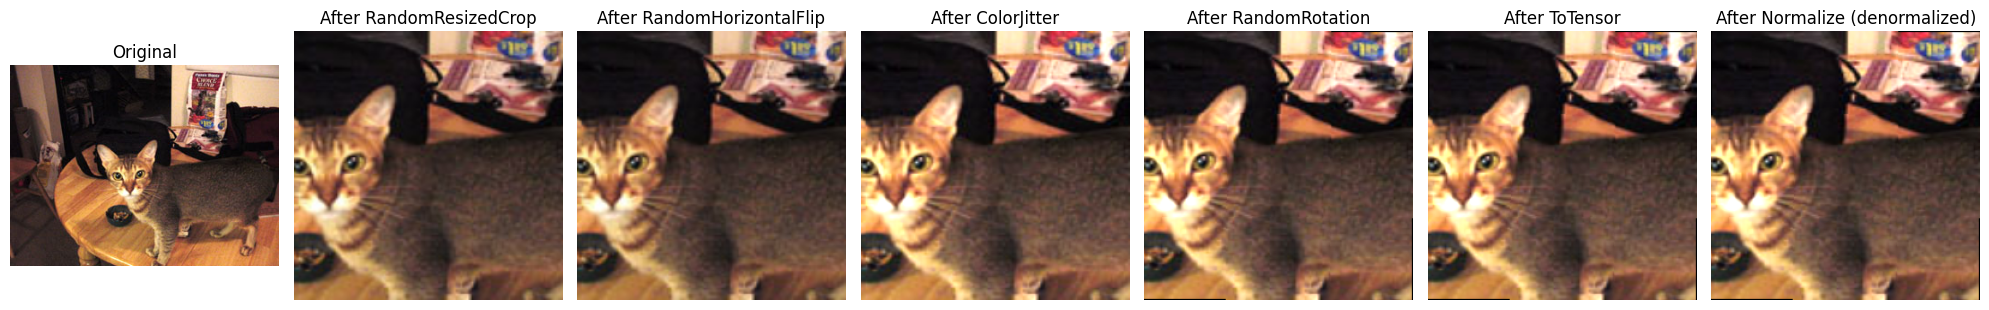

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Define the denormalization function for tensor visualization
def denormalize(tensor, mean, std):
    """Reverse normalization for visualization."""
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize: multiply by std, add mean
    return tensor

# Set paths (adjust these to match your data directory)
data_dir = "../data"  # Replace with your data_dir
img_dir = os.path.join(data_dir, "images")
annotation_file = os.path.join(data_dir, "annotations", "test.txt")

# Load a sample image from the test dataset
with open(annotation_file, "r") as f:
    line = f.readline().strip()
    img_name = line.split()[0] + ".jpg"  # Assumes format: "image_name class_id ..."
img_path = os.path.join(img_dir, img_name)
image = Image.open(img_path).convert("RGB")  # Load as PIL image in RGB

# Define individual transformations from get_data_loaders
crop = transforms.RandomResizedCrop(224)
flip = transforms.RandomHorizontalFlip()
jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2)
rotate = transforms.RandomRotation(10)
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# List to store images and titles for visualization
images = []
titles = []

# Step 1: Original Image
images.append(np.array(image))
titles.append("Original")

# Step 2: RandomResizedCrop
cropped = crop(image)
images.append(np.array(cropped))
titles.append("After RandomResizedCrop")

# Step 3: RandomHorizontalFlip
flipped = flip(cropped)
images.append(np.array(flipped))
titles.append("After RandomHorizontalFlip")

# Step 4: ColorJitter
jittered = jitter(flipped)
images.append(np.array(jittered))
titles.append("After ColorJitter")

# Step 5: RandomRotation
rotated = rotate(jittered)
images.append(np.array(rotated))
titles.append("After RandomRotation")

# Step 6: ToTensor
tensor = to_tensor(rotated)
images.append(tensor.permute(1, 2, 0).numpy())  # Convert [C,H,W] to [H,W,C]
titles.append("After ToTensor")

# Step 7: Normalize (and denormalize for visualization)
normalized = normalize(tensor)
denorm = denormalize(normalized, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denorm = torch.clamp(denorm, 0, 1)  # Ensure values stay in [0,1]
images.append(denorm.permute(1, 2, 0).numpy())
titles.append("After Normalize (denormalized)")

# Create a figure with subplots to display all steps
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")  # Hide axes for cleaner display
plt.tight_layout()
plt.show()

## Model Training

We use a pre-trained MobileNet34 model, modify its classifier, and train it on our dataset.

### Model Setup

- **Base Model**: MobileNet34 from `torchvision`, pre-trained on ImageNet.
- **Modifications**: Replace the final fully connected layer with:
  - Dropout (0.3) to prevent overfitting.
  - Linear layer for 37 classes (Oxford Pet Dataset has 37 breeds).
- **Loss**: Cross-Entropy Loss for multi-class classification.
- **Optimizer**: SGD with momentum (0.9) and learning rate 0.015.
- **Scheduler**: Reduces learning rate when validation loss plateaus.

### Training Process

- Runs for 30 epochs.
- Tracks loss and accuracy for training and validation.
- Saves the model with a timestamp and accuracy in the filename.
- Keeps only the last 5 model checkpoints.
- Plots accuracy and loss curves.

Epoch [1/40] | Train Loss: 3.7623 | Train Acc: 31.69% | Val Loss: 1.5789 | Val Acc: 55.43%
Epoch [2/40] | Train Loss: 1.3620 | Train Acc: 60.19% | Val Loss: 1.1910 | Val Acc: 66.30%
Epoch [3/40] | Train Loss: 1.0534 | Train Acc: 69.16% | Val Loss: 1.0493 | Val Acc: 68.75%
Epoch [4/40] | Train Loss: 0.8794 | Train Acc: 73.71% | Val Loss: 0.9538 | Val Acc: 71.33%
Epoch [5/40] | Train Loss: 0.8357 | Train Acc: 75.44% | Val Loss: 1.0268 | Val Acc: 68.89%
Epoch [6/40] | Train Loss: 0.7726 | Train Acc: 75.37% | Val Loss: 0.8695 | Val Acc: 75.00%
Epoch [7/40] | Train Loss: 0.7232 | Train Acc: 78.29% | Val Loss: 0.9087 | Val Acc: 72.83%
Epoch [8/40] | Train Loss: 0.6284 | Train Acc: 81.42% | Val Loss: 0.7796 | Val Acc: 77.31%
Epoch [9/40] | Train Loss: 0.5858 | Train Acc: 82.40% | Val Loss: 0.8496 | Val Acc: 76.09%
Epoch [10/40] | Train Loss: 0.5560 | Train Acc: 83.08% | Val Loss: 0.8152 | Val Acc: 76.77%
Epoch [11/40] | Train Loss: 0.5921 | Train Acc: 82.10% | Val Loss: 0.7721 | Val Acc: 76.3

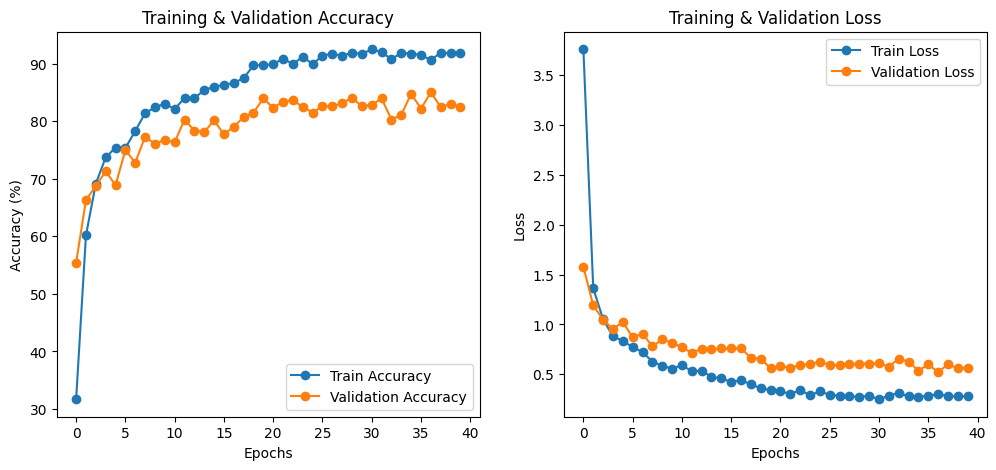

In [9]:
# Load data loaders
train_loader, val_loader, _ = get_data_loaders(data_dir)
weights_dir = "../weights/"
os.makedirs(weights_dir, exist_ok=True)

# Load pre-trained MobileNet
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Add dropout to reduce overfitting
    nn.Linear(num_ftrs, 37)  # Output 37 classes/
)

# let's unfreeze some layers 
for param in model.classifier.parameters():
    param.requires_grad = True  # Unfreeze all layers


# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.014, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=4)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()  # Training mode
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()  # Evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)  # Adjust learning rate

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# best accuracy
last_val_acc = val_accuracies[-1]
avg_val_acc = sum(val_accuracies[-5:]) / 5

# Save model with timestamp and accuracy
timestamp = datetime.datetime.now().strftime("%d-%H")
model_filename = f"{weights_dir}MobileNet_{avg_val_acc:.2f}acc_{timestamp}.pth"
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

# Keep only the last 5 models
model_files = sorted(glob.glob(f"{weights_dir}MobileNet_*.pth"), key=os.path.getctime, reverse=True)
for old_file in model_files[5:]:
    os.remove(old_file)
    print(f"Deleted old model: {old_file}")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

## Testing and Evaluation

Finally, we evaluate the trained model on the test set and analyze its performance.

### Testing Process

- Loads the saved model weights.
- Runs inference on the test set.
- Collects true and predicted labels.

### Evaluation Metrics

- **Classification Report**: Shows precision, recall, and F1-score for each class.
- **Confusion Matrix**: Visualizes correct and incorrect predictions across all 37 classes.


Classification Report:
              precision    recall  f1-score   support

           0     0.7778    0.7857    0.7817        98
           1     0.6131    0.8400    0.7089       100
           2     0.6615    0.4300    0.5212       100
           3     0.8925    0.8300    0.8601       100
           4     0.6814    0.7700    0.7230       100
           5     0.6964    0.7800    0.7358       100
           6     0.7576    0.7500    0.7538       100
           7     0.8434    0.7955    0.8187        88
           8     0.7857    0.7778    0.7817        99
           9     0.7701    0.6700    0.7166       100
          10     0.7727    0.6800    0.7234       100
          11     0.8020    0.8351    0.8182        97
          12     0.7264    0.7700    0.7476       100
          13     0.7979    0.7500    0.7732       100
          14     0.7583    0.9100    0.8273       100
          15     0.7321    0.8200    0.7736       100
          16     0.7477    0.8300    0.7867       100
   

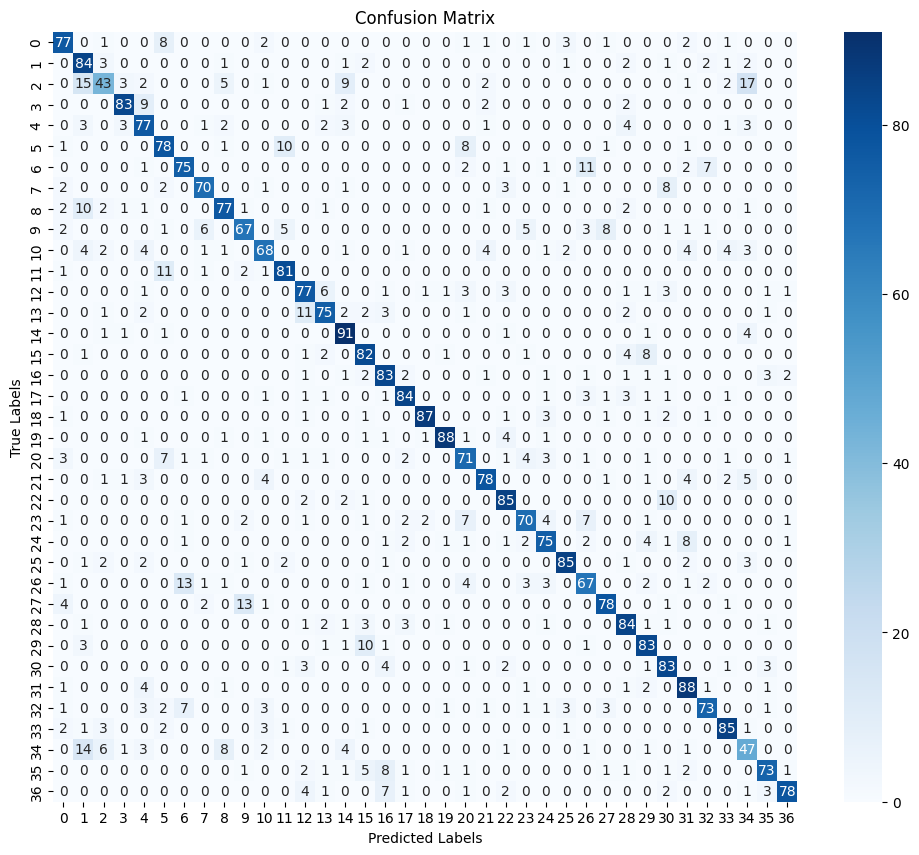

In [11]:
# Load test data
_, _, test_loader = get_data_loaders(data_dir)

# Load model
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout is disabled in eval mode
    nn.Linear(num_ftrs, 37)
)
model_path = f"{weights_dir}Mobilenet_83.04acc_17-02.pth"  # Update with your model file
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Test the model
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(37), yticklabels=np.arange(37))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

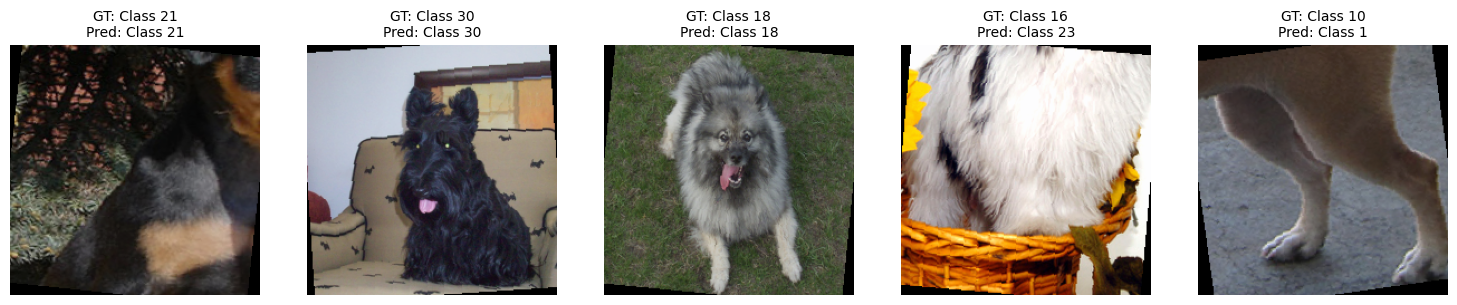

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# Load test data
_, _, test_loader = get_data_loaders("../data/")  # Assuming test_loader is defined in preprocess.py

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout is disabled in eval mode
    nn.Linear(num_ftrs, 37)
)
model.load_state_dict(torch.load("../weights/Mobilenet_83.04acc_17-02.pth", map_location=device))  # Load trained weights
model.to(device)
model.eval()

# Define class names (example; replace with actual names from Oxford-IIIT Pet Dataset if available)
class_names = [f"Class {i}" for i in range(37)]  # Placeholder; use real names if you have them

# Initialize variables for evaluation
y_true, y_pred = [], []

# Perform testing and collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



# Visualize random sample images with predicted and ground truth labels
def visualize_samples(loader, model, class_names, num_samples=5):
    model.eval()
    
    # Collect all images and labels from the test loader
    all_images = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            all_images.append(images)  # Store images
            all_labels.append(labels)  # Store labels
    
    # Concatenate all batches into single tensors
    all_images = torch.cat(all_images, dim=0)  # Shape: (total_samples, C, H, W)
    all_labels = torch.cat(all_labels, dim=0)  # Shape: (total_samples,)

    # Randomly select indices for visualization
    total_samples = len(all_labels)
    if total_samples < num_samples:
        num_samples = total_samples  # Adjust if dataset is smaller than num_samples
    random_indices = random.sample(range(total_samples), num_samples)  # Pick random indices

    # Get the selected images and labels
    selected_images = all_images[random_indices].to(device)
    selected_labels = all_labels[random_indices]

    # Run inference on the selected images
    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)

    # Move data back to CPU for visualization
    selected_images = selected_images.cpu()
    selected_labels = selected_labels.numpy()
    predicted = predicted.cpu().numpy()

    # Plot the random samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(range(num_samples)):
        # Denormalize the image for display
        img = selected_images[idx].permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization
        img = np.clip(img, 0, 1)  # Ensure values are in [0, 1] range

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"GT: {class_names[selected_labels[idx]]}\nPred: {class_names[predicted[idx]]}", fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_samples(test_loader, model, class_names, num_samples=5)